# Refer to SF EDA notebook for Price EDA (Section 5 & 10)

# Import Libraries

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [181]:
SF_df = pd.read_pickle("pre-processing and EDA/cleaned_price_df.pkl")
SF_df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price_log
0,within an hour,1.0,0.99,1,1,Western Addition,Entire apartment,Entire home/apt,3,1.0,1.0,2.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",132.0,2,30,257,97.0,1.91,4.882802
1,within a day,0.6,0.83,0,2,Bernal Heights,Entire apartment,Entire home/apt,5,1.0,2.0,3.0,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",235.0,30,60,111,98.0,0.81,5.459586
2,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,60,19,84.0,0.14,4.025352
3,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,90,8,93.0,0.11,4.025352
5,within an hour,1.0,0.96,1,2,Mission,Private room in condominium,Private room,3,1.0,1.0,1.0,"[""Heating"", ""Hot water"", ""Children\u2019s book...",169.0,1,14,736,98.0,5.47,5.129899


In [182]:
SF_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 7273
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6848 non-null   object 
 1   host_response_rate      6848 non-null   float64
 2   host_acceptance_rate    6848 non-null   float64
 3   host_is_superhost       6848 non-null   int32  
 4   host_listings_count     6848 non-null   int64  
 5   neighbourhood_cleansed  6848 non-null   object 
 6   property_type           6848 non-null   object 
 7   room_type               6848 non-null   object 
 8   accommodates            6848 non-null   int64  
 9   bathrooms               6848 non-null   float64
 10  bedrooms                6848 non-null   float64
 11  beds                    6848 non-null   float64
 12  amenities               6848 non-null   object 
 13  price                   6848 non-null   float64
 14  minimum_nights          6848 non-null   

# Different column type name lists

In [183]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = SF_df.select_dtypes(include=numerics).columns.to_list()
bool_columns = SF_df.select_dtypes(include='bool').columns.to_list()
object_columns = SF_df.select_dtypes(include='object').columns.to_list()
print(object_columns)

['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']


# Filter out price outliers

In [184]:
IQR_value = 633 #based on price box plot from SF EDA notebook -> 3*IQR value
SFprice_filtered_df = SF_df[SF_df.price <= IQR_value]
SFprice_filtered_df["price"].describe(percentiles=[0.1,0.25, 0.5, 0.75,0.9])

count    6848.000000
mean      166.581157
std       111.840100
min        10.000000
10%        60.000000
25%        88.000000
50%       135.000000
75%       206.000000
90%       315.797000
max       633.000000
Name: price, dtype: float64

In [185]:
SFprice_filtered_df.isnull().sum()

host_response_time        0
host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_listings_count       0
neighbourhood_cleansed    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
reviews_per_month         0
price_log                 0
dtype: int64

# Correlations for Numeric Columns

In [186]:
#sns.set(style="ticks", color_codes=True)
#sns.pairplot(SFprice_filtered_df[numeric_columns])

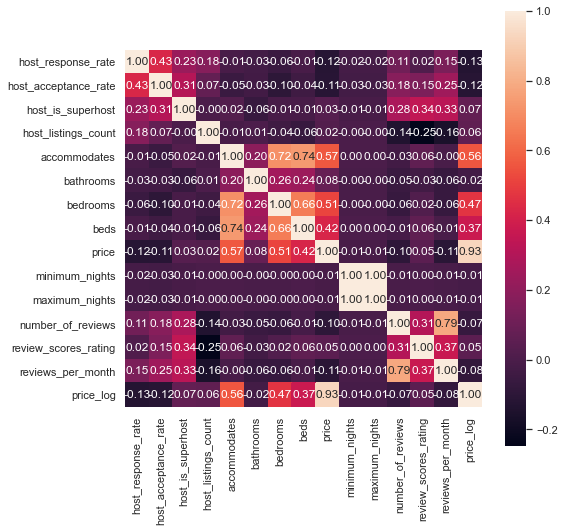

In [187]:
corr = SFprice_filtered_df[numeric_columns].corr()
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=numeric_columns, yticklabels=numeric_columns)

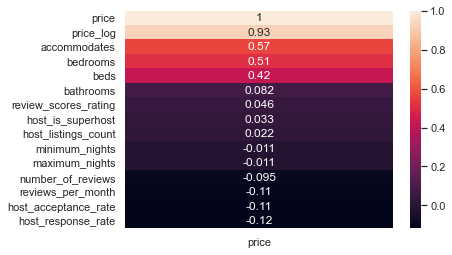

In [188]:
sns.heatmap(corr[['price']].sort_values(['price'],ascending=False),yticklabels=True,annot=True)

In [189]:
SFprice_filtered_df["host_is_superhost"]

0       1
1       0
2       0
3       0
5       1
       ..
7269    0
7270    0
7271    0
7272    0
7273    1
Name: host_is_superhost, Length: 6848, dtype: int32

# Data Pre-processing for non-numeric columns

## Converting bool to numeric

In [190]:
for column in bool_columns:
    SFprice_filtered_df[column] = SFprice_filtered_df[column].replace(False,0,regex=True)
    SFprice_filtered_df[column] = SFprice_filtered_df[column].replace(True,1,regex=True)
SFprice_filtered_df["host_is_superhost"].head()

0    1
1    0
2    0
3    0
5    1
Name: host_is_superhost, dtype: int32

## Transforming amenities to numeric columns

In [191]:
SFprice_filtered_df.amenities = SFprice_filtered_df.amenities.str.replace('"', "")
SFprice_filtered_df.amenities = SFprice_filtered_df.amenities.str.replace("[", "")
SFprice_filtered_df.amenities = SFprice_filtered_df.amenities.str.replace("]", "")
SFprice_filtered_df['amenities'].head()

0    Heating, Hot water, Stove, Iron, Dryer, Coffee...
1    Smoke alarm, Heating, Kitchen, First aid kit, ...
2    Host greets you, Heating, Hot water, Kitchen, ...
3    Host greets you, Heating, Hot water, Kitchen, ...
5    Heating, Hot water, Children\u2019s books and ...
Name: amenities, dtype: object

In [192]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(', '))
amenities = count_vectorizer.fit_transform(SFprice_filtered_df['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

In [193]:
len(df_amenities.columns.to_list())

115

In [194]:
df_amenities.columns.to_list()

['air conditioning',
 'alarm system',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'baking sheet',
 'barbecue utensils',
 'bathroom essentials',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bread maker',
 'breakfast',
 'breakfast bar',
 'building staff',
 'cable tv',
 'carbon monoxide alarm',
 'changing table',
 'children\\u2019s books and toys',
 'children\\u2019s dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'cooking basics',
 'crib',
 'desk',
 'dishes and silverware',
 'dishwasher',
 'dryer',
 'dual vanity',
 'elevator',
 'essentials',
 'ethernet connection',
 'ev charger',
 'extra pillows and blankets',
 'fire extinguisher',
 'fireplace guards',
 'first aid kit',
 'free parking on premises',
 'free street parking',
 'full kitchen',
 'game console',
 'garden or backyard',
 'gas fireplace',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'high chair',
 'host greets you',
 'hot tub',
 'hot water',
 

In [195]:
listings_new = SFprice_filtered_df[numeric_columns+bool_columns]
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price_log
0,1.0,0.99,1,1,3,1.0,1.0,2.0,132.0,2,30,257,97.0,1.91,4.882802
1,0.6,0.83,0,2,5,1.0,2.0,3.0,235.0,30,60,111,98.0,0.81,5.459586
2,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,60,19,84.0,0.14,4.025352
3,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,90,8,93.0,0.11,4.025352
5,1.0,0.96,1,2,3,1.0,1.0,1.0,169.0,1,14,736,98.0,5.47,5.129899


## Transforming categorical columns to numeric columns and creating new df

In [196]:
for categorical_col in object_columns[:-1]:
    listings_new = pd.concat([listings_new, pd.get_dummies(SFprice_filtered_df[categorical_col])], axis=1)

In [197]:
#listings_new.columns.to_list()
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,Shared room in hostel,Shared room in house,Shared room in loft,Shared room in townhouse,Shared room in villa,Tiny house,Entire home/apt,Hotel room,Private room,Shared room
0,1.0,0.99,1,1,3,1.0,1.0,2.0,132.0,2,...,0,0,0,0,0,0,1,0,0,0
1,0.6,0.83,0,2,5,1.0,2.0,3.0,235.0,30,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,...,0,0,0,0,0,0,0,0,1,0
5,1.0,0.96,1,2,3,1.0,1.0,1.0,169.0,1,...,0,0,0,0,0,0,0,0,1,0


In [198]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,1.0,0.99,1,1,3,1.0,1.0,2.0,132.0,2,...,0,0,1,0,1,0,0,1,0,0
1,0.6,0.83,0,2,5,1.0,2.0,3.0,235.0,30,...,0,0,0,0,1,0,0,1,0,0
2,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,...,0,0,1,0,1,0,0,1,0,0
3,1.0,1.00,0,10,2,4.0,1.0,1.0,56.0,32,...,0,0,1,0,1,0,0,1,0,0
5,1.0,0.96,1,2,3,1.0,1.0,1.0,169.0,1,...,0,0,1,0,1,0,0,1,0,0


In [199]:
listings_new.columns.to_list()
# listings_new.columns.duplicated()

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'reviews_per_month',
 'price_log',
 '-',
 'a few days or more',
 'within a day',
 'within a few hours',
 'within an hour',
 'Bayview',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Crocker Amazon',
 'Diamond Heights',
 'Downtown/Civic Center',
 'Excelsior',
 'Financial District',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Inner Richmond',
 'Inner Sunset',
 'Lakeshore',
 'Marina',
 'Mission',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Ocean View',
 'Outer Mission',
 'Outer Richmond',
 'Outer Sunset',
 'Pacific Heights',
 'Parkside',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Treasure Island/YBI',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Wes

## Check for Duplicates

In [200]:
if listings_new.duplicated().any():
    duplicate_rows = listings_new[listings_new.duplicated()]
    print("Duplicates Removed")
print(listings_new.duplicated().any())

False


In [201]:
# rename duplicate column
listings_new.columns = \
['host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'reviews_per_month',
 'host_is_superhost',
 '-',
 'a few days or more',
 'within a day',
 'within a few hours',
 'within an hour',
 'Bayview',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Crocker Amazon',
 'Diamond Heights',
 'Downtown/Civic Center',
 'Excelsior',
 'Financial District',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Inner Richmond',
 'Inner Sunset',
 'Lakeshore',
 'Marina',
 'Mission',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Ocean View',
 'Outer Mission',
 'Outer Richmond',
 'Outer Sunset',
 'Pacific Heights',
 'Parkside',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Treasure Island/YBI',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Western Addition',
 'Boat',
 'Casa particular',
 'Earth house',
 'Entire apartment',
 'Entire bungalow',
 'Entire cabin',
 'Entire condominium',
 'Entire cottage',
 'Entire floor',
 'Entire guest suite',
 'Entire guesthouse',
 'Entire house',
 'Entire in-law',
 'Entire loft',
 'Entire place',
 'Entire serviced apartment',
 'Entire townhouse',
 'Entire villa',
 'Private room (Property Type)',
 'Private room in apartment',
 'Private room in bed and breakfast',
 'Private room in bungalow',
 'Private room in cabin',
 'Private room in castle',
 'Private room in condominium',
 'Private room in cottage',
 'Private room in earth house',
 'Private room in guest suite',
 'Private room in guesthouse',
 'Private room in hostel',
 'Private room in house',
 'Private room in hut',
 'Private room in loft',
 'Private room in resort',
 'Private room in serviced apartment',
 'Private room in townhouse',
 'Private room in villa',
 'Room in aparthotel',
 'Room in bed and breakfast',
 'Room in boutique hotel',
 'Room in hostel',
 'Room in hotel',
 'Room in serviced apartment',
 'Shared room in apartment',
 'Shared room in bed and breakfast',
 'Shared room in boutique hotel',
 'Shared room in bungalow',
 'Shared room in condominium',
 'Shared room in hostel',
 'Shared room in house',
 'Shared room in loft',
 'Shared room in townhouse',
 'Shared room in villa',
 'Tiny house',
 'Entire home/apt',
 'Hotel room',
 'Private room',
 'Shared room',
 'air conditioning',
 'alarm system',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'baking sheet',
 'barbecue utensils',
 'bathroom essentials',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bread maker',
 'breakfast',
 'breakfast bar',
 'building staff',
 'cable tv',
 'carbon monoxide alarm',
 'changing table',
 'children\\u2019s books and toys',
 'children\\u2019s dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'cooking basics',
 'crib',
 'desk',
 'dishes and silverware',
 'dishwasher',
 'dryer',
 'dual vanity',
 'elevator',
 'essentials',
 'ethernet connection',
 'ev charger',
 'extra pillows and blankets',
 'fire extinguisher',
 'fireplace guards',
 'first aid kit',
 'free parking on premises',
 'free street parking',
 'full kitchen',
 'game console',
 'garden or backyard',
 'gas fireplace',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'high chair',
 'host greets you',
 'hot tub',
 'hot water',
 'indoor fireplace',
 'iron',
 'ironing board',
 'jetted tub',
 'keypad',
 'kitchen',
 'kitchenette',
 'lake access',
 'laptop-friendly workspace',
 'lock on bedroom door',
 'lockbox',
 'long term stays allowed',
 'luggage dropoff allowed',
 'microwave',
 'mini fridge',
 'natural gas barbeque',
 'office',
 'outlet covers',
 'oven',
 'pack \\u2019n play/travel crib',
 'paid parking off premises',
 'paid parking on premises',
 'patio or balcony',
 'pets allowed',
 'piano',
 'pocket wifi',
 'pool',
 'portable air conditioning',
 'private entrance',
 'private hot tub',
 'private living room',
 'refrigerator',
 'room-darkening shades',
 'security cameras',
 'self check-in',
 'shampoo',
 'shared hot tub',
 'shower gel',
 'single level home',
 'ski-in/ski-out',
 'smart home technology',
 'smart lock',
 'smart tv',
 'smoke alarm',
 'smoking allowed',
 'sonos sound system',
 'stair gates',
 'stand alone bathtub',
 'stand alone rain shower',
 'stove',
 'suitable for events',
 'table corner guards',
 'terrace',
 'tv',
 'walk in closet',
 'washer',
 'waterfront',
 'wet bar',
 'wifi',
 'window guards',
 'wine cooler']


ValueError: Length mismatch: Expected axis has 230 elements, new values have 229 elements

In [ ]:
listings_new.to_pickle('listings_for_analysis.pkl')


pickle_listings_new_df = pd.read_pickle('listings_for_analysis.pkl')
pickle_listings_new_df.head(5)

# Random Forest

## Train/Test w Random Forest Algorithm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

# y = listings_new['price']
# x = listings_new.drop('price', axis =1)
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
# rf = RandomForestRegressor(n_estimators=96, 
#                                criterion='mse', 
#                                random_state=3, 
#                                n_jobs=-1)
# rf.fit(X_train, y_train)
# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)
# rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

# print('RMSE test: %.3f' % rmse_rf)
# print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

## Feature Importance of Random Forest Algorithm

In [ ]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

In [ ]:

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

# LightGBM

## Train/Test w LightGBM

In [ ]:
from lightgbm import LGBMRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }
        
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
        
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

## Feature Importance of LightGBM

In [ ]:
feat_imp = pd.Series(clf.feature_importances_, index=x.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

In [ ]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = x.columns
coefs_df['coefs'] = clf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)